In [1]:
import os.path as op
import mne
import numpy as np
from mne.datasets import fetch_fsaverage
from mne.minimum_norm import make_inverse_operator, apply_inverse,apply_inverse_raw, apply_inverse_epochs
import numpy as np
from sklearn.svm import SVC
from sklearn.cluster import KMeans

In [2]:
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import accuracy_score

In [3]:
import pandas as pd
from mne import concatenate_raws, events_from_annotations
from mne.io import read_raw_edf
from mne.channels import make_standard_montage 

import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC

In [4]:
subject=1
raw_fnames = eegbci.load_data(subject, [3])
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
raw.rename_channels(lambda x: x.strip('.'))
raw.rename_channels(lambda x: x.replace('Cp','CP'))
raw.rename_channels(lambda x: x.replace('Fc','FC'))
raw.rename_channels(lambda x: x.replace('Af','AF'))
raw.rename_channels(lambda x: x.replace('Ft','FT'))
raw.rename_channels(lambda x: x.replace('Tp','TP'))
raw.rename_channels(lambda x: x.replace('Po','PO'))


montage = make_standard_montage('standard_1005')
raw.set_montage(montage)

Extracting EDF parameters from C:\Users\CBI\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


<RawEDF | S001R03.edf, 64 x 20000 (125.0 s), ~9.9 MB, data loaded>

In [5]:
fs_dir = fetch_fsaverage(verbose=True)
subjects_dir = op.dirname(fs_dir)
subject='fsaverage'

0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage


In [8]:
def all_about_forward(raw,subjects_dir,subject='fsaverage'):
    

    subject = 'fsaverage'
    trans = 'fsaverage'  # MNE has a built-in fsaverage transformation
    src = op.join(fs_dir, 'bem', 'fsaverage-ico-5-src.fif')
    bem = op.join(fs_dir, 'bem', 'fsaverage-5120-5120-5120-bem-sol.fif')
    
    montage = mne.channels.make_standard_montage('standard_1005')
    
    dic={}

    for i in range(len(raw.ch_names)):

        kek=raw.ch_names[i].replace('.','').upper()
        kek=kek.replace('Z','z')
        kek=kek.replace('FP1','Fp1')
        kek=kek.replace('FP2','Fp2')
        kek=kek.replace('FPz','Fpz')
        dic[raw.ch_names[i]]=kek
    
    
    raw.rename_channels(mapping=dic)
    raw.set_montage(montage)
    raw.set_eeg_reference(projection=True)
    events, _ = mne.events_from_annotations(raw, event_id=dict(T1=2, T2=3))

    cov = mne.compute_raw_covariance(raw)

    fwd = mne.make_forward_solution(raw.info, trans=trans, src=src,
                                    bem=bem, eeg=True, mindist=5.0, n_jobs=1)
    #print(fwd)

    # Use fwd to compute the sensitivity map for illustration purposes
    
    cov = mne.compute_raw_covariance(raw)

    
    
    return raw,cov,fwd

In [9]:
fs_dir = fetch_fsaverage(verbose=True)
subjects_dir = op.dirname(fs_dir)
subject='fsaverage'
        
raw, cov,fwd=all_about_forward(raw,subjects_dir)        

left_hemi,right_hemi=fwd["src"]
#left_hemi

0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Used Annotations descriptions: ['T1', 'T2']
Using up to 625 segments
Number of samples used : 20000
[done]
Source space          : C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\bem\fsaverage-ico-5-src.fif
MRI -> head transform : C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\mne\data\fsaverage\fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\bem\fsaverage-5120-5120-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Reading C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\bem\fsaverage-ico-5-src.fif.

In [10]:
cov_data = np.identity(64)

cov = mne.Covariance(
        cov_data, raw.info.ch_names, raw.info["bads"], raw.info["projs"], nfree=1
)



In [11]:
inv = make_inverse_operator(raw.info, fwd, cov, loose=0., depth=0.8,
                            verbose=True)

Computing inverse operator with 64 channels.
    64 out of 64 channels remain after picking
Selected 64 channels
Creating the depth weighting matrix...
    64 EEG channels
    limit = 20485/20484 = 2.162502
    scale = 116332 exp = 0.8
    Picked elements from a free-orientation depth-weighting prior into the fixed-orientation one
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Changing to fixed-orientation forward solution with surface-based source orientations...
    [done]
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 0.00014 (2.2e-16 eps * 64 dim * 1e+10  max singular value)
    Estimated rank (eeg): 63
    EEG: rank 63 computed from 64 data channels with 1 projector
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matr

In [12]:
raw_example=raw.copy().crop(0,20)

In [13]:
def events_matrix_from_list(stim_initial):
    events_matrix=[]
    for i in range(1,len(stim_initial)):
        if stim_initial[i]!=stim_initial[i-1]:
            events_matrix.append([i,0,str(int(stim_initial[i]))])
        
    events_matrix=np.array(events_matrix)
    
    return events_matrix.astype(int)

### Решить обартную задачу в области и с преобразованием гильберта

In [14]:
labels=mne.read_labels_from_annot(subject, 
                               parc='aparc', 
                               hemi='both', 
                               surf_name='pial', 
                               annot_fname=None, 
                               regexp=None, 
                               subjects_dir=subjects_dir, 
                               #sort=True, 
                                  verbose=None)

Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot


In [15]:
def all_about_labels(fwd,subject_dir='fsaverage',subject='fsaverage'):

        fs_dir = fetch_fsaverage(verbose=True)
        subject_dir = op.dirname(fs_dir)
        
        labels=extract_labels(subject,subject_dir)

        left_hemi,right_hemi=fwd["src"]

        sources_idx=np.r_[left_hemi["vertno"],right_hemi["vertno"]+len(left_hemi["vertno"])]
        print(sources_idx)
        sources_idx=left_hemi["vertno"]
        vertices_i_need=[]
        labels_i_need=[]
        poses=np.zeros((0,3))
        
        for i in range(len(labels)):
            labels[i].forward_vertices=np.where(np.isin(sources_idx,labels[i].vertices))[0]
            labels_i_need.append(labels[i])

            if labels[i].name[-2:]=='lh':
                vertices_i_need=np.concatenate([vertices_i_need,labels[i].forward_vertices])
                inds_in_this_label=[labels[i].vertices.tolist().index(k) for k in labels[i].forward_vertices]
                poses=np.concatenate([poses,labels[i].pos[inds_in_this_label,:]])

            elif labels[i].name[-2:]=='rh':
                vertices_i_need=np.concatenate([vertices_i_need,labels[i].forward_vertices+fwd['source_rr'].shape[0]/2])
                inds_in_this_label=[labels[i].vertices.tolist().index(k) for k in labels[i].forward_vertices ]
                poses=np.concatenate([poses,labels[i].pos[inds_in_this_label,:]])

        vertices_i_need_three_orient=threeplet(vertices_i_need)
        vertices_i_need_three_orient=np.array(vertices_i_need_three_orient).astype(int)

        return vertices_i_need_three_orient


In [16]:
def threeplet(vertices_i_need):
    vertices_i_need_three=[]

    for i in range(len(vertices_i_need)):
        vertices_i_need_three.append(vertices_i_need[i]*3)
        vertices_i_need_three.append(vertices_i_need[i]*3+1)
        vertices_i_need_three.append(vertices_i_need[i]*3+2)

    return vertices_i_need_three

def return_gain_matrix(fwd):
    gain_matrix=fwd['sol']['data']
    return gain_matrix

def return_gain_matrix_ROI(fwd,vertices_i_need_three_orient):

    gain_matrix=return_gain_matrix(fwd)
    gain_matrix_small=gain_matrix[:,vertices_i_need_three_orient]
    return gain_matrix_small


def clusterization_of_gain(gain_matrix_small,cluster_num=30):
    X_inds=np.arange(0,gain_matrix_small.shape[1],3)
    Y_inds=X_inds+1
    Z_inds=X_inds+2

    gain_X=gain_matrix_small[:,X_inds]
    gain_Y=gain_matrix_small[:,Y_inds]
    gain_Z=gain_matrix_small[:,Z_inds]

    gain_all=np.concatenate([gain_X,gain_Y,gain_Z]).T

    km=KMeans(cluster_num)
    #km = AgglomerativeClustering(cluster_num)

    km.fit(gain_all)

    cluster_ids=km.fit_predict(gain_all)

    return cluster_ids


In [17]:
def return_gain_matrix(fwd):
    gain_matrix=fwd['sol']['data']
    return gain_matrix


In [18]:
def extract_labels(subject,subjects_dir):

    labels=mne.read_labels_from_annot(subject,  parc='aparc',   hemi='both', surf_name='pial', 
                               annot_fname=None,  regexp=None,  subjects_dir=subjects_dir,   verbose=None)

    return [labels[44],labels[45],labels[48],labels[49]]

def create_source_data(raw,fwd,inv,fs=0,mode='mean'):
    
    # Сейчас здесь только усреднение
    '''
    mode: describes data in which sense will be sent back
        'mean' -
        'full' -
    '''
    
    
    fs_dir = fetch_fsaverage(verbose=True)
    subjects_dir = op.dirname(fs_dir)
    subject='fsaverage'

    labels=extract_labels(subject,subjects_dir)
    
    print(labels)
    if type(raw) is np.ndarray:
        raw_matrix=raw
        fs=fs
    else:
        raw_matrix=raw.get_data()
        fs=raw.info['sfreq']

    alpha_raw=raw.copy().filter(8,12,phase='zero')
    alpha_raw=alpha_raw.apply_hilbert()

    betta_raw=raw.copy().filter(15,25,phase='zero')
    betta_raw=betta_raw.apply_hilbert()


    sources_list=[]
    for i in range(len(labels)):
        label=labels[i]
        #source_alpha= np.mean(abs(apply_inverse_raw(alpha_raw, inv, lambda2=0.01, method= 'MNE', label=label).data),0)
        #source_betta= np.mean(abs(apply_inverse_raw(betta_raw, inv, lambda2=0.01, method= 'MNE', label=label).data),0)
        
        if mode=='mean':
            source_alpha= np.mean(abs(apply_inverse_epochs(alpha_raw, inv, lambda2=0.1, method= 'sLORETA', label=label)[0].data),0)
            source_betta= np.mean(abs(apply_inverse_epochs(betta_raw, inv, lambda2=0.1, method= 'sLORETA', label=label)[0].data),0)

            sources_list.append(source_alpha)
            sources_list.append(source_betta)
            
        elif mode=='full':
            
            source_alpha= abs(apply_inverse_epochs(alpha_raw, inv, lambda2=0.1, method= 'sLORETA', label=label)[0].data)
            #source_betta= abs(apply_inverse_epochs(betta_raw, inv, lambda2=0.1, method= 'sLORETA', label=label)[0].data)

            sources_list.append(source_alpha)
            #sources_list.append(source_betta)
            
            

    clusters_data=np.vstack(sources_list)

    return clusters_data

In [19]:
labels=extract_labels('fsaverage',subjects_dir)

Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot


In [20]:
vertices=all_about_labels(fwd,subject_dir='fsaverage',subject='fsaverage')

0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[    0     1     2 ... 20481 20482 20483]


In [21]:
gain_matrix_ROI=return_gain_matrix_ROI(fwd,vertices)

In [22]:
clusters=clusterization_of_gain(gain_matrix_ROI,20)

(array([206.,  95., 100.,  86., 127., 110., 123., 111., 157., 173., 154.,
        101., 127., 118., 125., 123.,  73.,  76., 135., 190.]),
 array([ 0.  ,  0.95,  1.9 ,  2.85,  3.8 ,  4.75,  5.7 ,  6.65,  7.6 ,
         8.55,  9.5 , 10.45, 11.4 , 12.35, 13.3 , 14.25, 15.2 , 16.15,
        17.1 , 18.05, 19.  ]),
 <BarContainer object of 20 artists>)

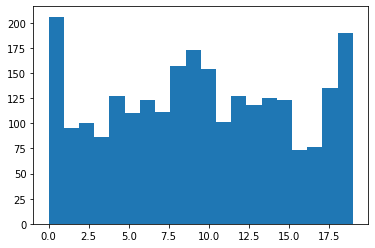

In [23]:
plt.hist(clusters,20)

In [24]:
from scipy.signal import butter, lfilter, savgol_coeffs,filtfilt

In [25]:
plt.figure()
aaa=[create_source_data(epochs['2'][i].copy(), fwd,inv,fs=250 ) for i in range(len(epochs['2']))]
plt.plot(aaa.T,alpha=.5)
#plt.plot(stim_initial[:10000])

NameError: name 'epochs' is not defined

<Figure size 432x288 with 0 Axes>

In [26]:

def make_data(raw,window,bias,states,Fs=160):

    try:
    
        time_samples=len(raw['Fz'][0][0])
    
    except :
        
        time_samples=len(np.arange(0,raw.shape[1]*1/Fs,1/Fs))
        
        
    list_of_states=[]
    train_data_list=[]

    for c in np.arange(0,(time_samples-(window-bias)),bias):

            sum_of_states=sum(states[c:c+window])

            if (sum_of_states%window)==0 and (sum_of_states/window)==states[c]:

                list_of_states.append(states[c])

                train_data_list.append(np.arange(c,(c+window)))


    return list_of_states, train_data_list


In [27]:
def make_training_set(epochs_data_train,events, concat_flg=True):

    X_all=[]
    Y_all=[]
    for i in range(len(epochs_data_train)):
        list_of_states_i, train_data_list_i=make_data(epochs_data_train[i],320,50,[events[i,2]]*epochs_data_train[i].shape[1])
        
        X_=[]

        for state_i in range(len(list_of_states_i)-1):
            #X_.append(np.mean(epochs_data_train[i][:,train_data_list_i[state_i]],1))
            X_.append(epochs_data_train[i][:,train_data_list_i[state_i]])

        X_all.append(X_)
        Y_all.append(list_of_states_i[:-1])
    
    X_all=np.array(X_all)
    Y_all=np.array(Y_all)
    
    if concat_flg:
        X_all=np.concatenate(X_all)
        Y_all=np.concatenate(Y_all)
    
    return X_all,Y_all

In [28]:
from mne.datasets import eegbci

In [29]:

#train_idx_s=[np.arange(0,len(epochs)-10)]
#test_idx_s=[np.arange(len(epochs)-10,len(epochs))]

df=pd.DataFrame(columns=['time','window','bias','tasks','csp_len','subject','validation_i','acc'])
windows=[2]
bias=[0.05]
tasks=[ 
    
    #[3, 7, 11], #Motor execution: left vs right hand
    #[4, 8, 12], #Motor imagery: left vs right hand
    [5, 9, 13], #Motor execution: hands vs feet
    #[6, 10, 14], #Motor imagery: hands vs feet

]

tain_ranges=[
    
    [0,4],
    #[1,5],
    #[1,7],
    #[0,8]
    
]


for tr in tain_ranges:

    for t in tasks:

        for w in windows:

            for b in bias:

                for i in [2]:


                    subject = i

                    tmin, tmax = -1., 7.
                    event_id = dict(hands=2, feet=3)

                    runs = t  # motor imagery: hands vs feet


                    raw_fnames = eegbci.load_data(subject, runs)
                    raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
                    raw.rename_channels(lambda x: x.strip('.'))
                    raw.rename_channels(lambda x: x.replace('Cp','CP'))
                    raw.rename_channels(lambda x: x.replace('Fc','FC'))
                    raw.rename_channels(lambda x: x.replace('Af','AF'))
                    raw.rename_channels(lambda x: x.replace('Ft','FT'))
                    raw.rename_channels(lambda x: x.replace('Tp','TP'))
                    raw.rename_channels(lambda x: x.replace('Po','PO'))


                    montage = make_standard_montage('standard_1005')
                    raw.set_montage(montage)

                    raw.rename_channels(lambda x: x.strip('.'))


                    raw.filter(7., 30., fir_design='firwin', skip_by_annotation='edge')

                    events, _ = events_from_annotations(raw, event_id=dict(T1=2, T2=3))

                    picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                                       exclude='bads')



                    epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                                    baseline=None, preload=True)
                    
                    
                    train_idx_s=[np.arange(10,len(epochs)),  np.concatenate([np.arange(0,10),np.arange(20,len(epochs))]),  np.concatenate([np.arange(0,20),np.arange(30,len(epochs))])  ,np.arange(0,len(epochs)-10)]
                    test_idx_s=[np.arange(0,10)           ,  np.arange(10,20)                                           ,  np.arange(20,30)                                             ,np.arange(len(epochs)-10,len(epochs))]

                    
                    train_range=tr
                    epochs_train_tmin=train_range[0]
                    epochs_train_tmax=train_range[1]

                    epochs_train = epochs.copy().crop(tmin=epochs_train_tmin, tmax=epochs_train_tmax)
                    
                    labels = epochs.events[:, -1] - 2

                    scores = []
                    #epochs_data = epochs.get_data()
                    #epochs_data_train = epochs_train.get_data()
                    
                    epochs_data=np.array([create_source_data(epochs[i].copy(), fwd,inv,fs=160,mode='full' ) for i in range(len(epochs))])
                    #epochs_data_train=[create_source_data(epochs_train[i].copy(), fwd,inv,fs=160 ) for i in range(len(epochs_train))]
                    epochs_data_train=epochs_data[:,:,160:-160]
                    epochs_data_train=np.array( [np.mean(epochs_data_train[:,np.where(clusters==i)[0],:],1) for i in range(20)] )
                    epochs_data_train=epochs_data_train.transpose(1,0,2)
                    
                    
                    
                    
                    
                    


                    

Extracting EDF parameters from C:\Users\CBI\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S002\S002R05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from C:\Users\CBI\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S002\S002R09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from C:\Users\CBI\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S002\S002R13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming win

    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <L


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Pr

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsavera

Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pa


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Set


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Pr

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsavera

Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pa


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Set


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Pr

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsavera

In [30]:
id_2=np.where(epochs_train.events[:,2]==2)[0].tolist()

In [31]:
id_3=np.where(epochs_train.events[:,2]==3)[0].tolist()

In [32]:
mean_2=np.mean(np.array([epochs_data_train[i] for i in id_2]),0)

In [33]:
mean_3=np.mean(np.array([epochs_data_train[i] for i in id_3]),0)

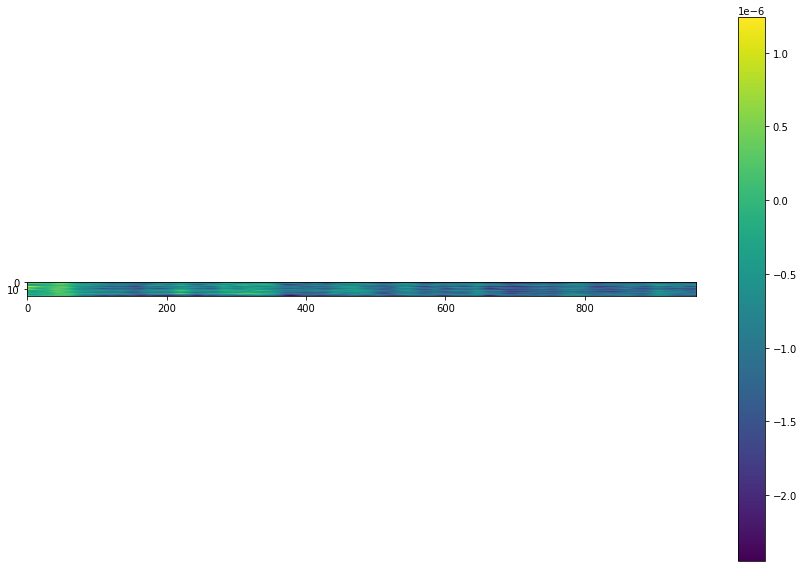

In [34]:
plt.figure(figsize=(15,10))

plt.imshow(mean_2-mean_3)
plt.colorbar()

In [987]:
plt.figure(figsize=(15,10))
plt.imshow(mean_2)
plt.show()
plt.figure(figsize=(15,10))
plt.imshow(mean_3)
plt.show()

In [988]:
plt.figure(figsize=(15,10))
[plt.plot(mean_2[i],label=str(i)+' 2') for i in range(8)]
plt.legend()
plt.show()
plt.figure(figsize=(15,10))
[plt.plot(mean_3[i],label=str(i)+' 3') for i in range(8)]
plt.legend()
plt.show()

In [154]:
#plt.figure(figsize=(15,10))
#plt.imshow(epochs_data_train[0])

In [158]:
import SourceSpaceTransformer_29998 as sst

In [159]:
SST=sst.SourceSpaceTransformer_2(param=1,fwd=fwd,cov='cov',subject='fsaverage',subjects_dir='ss',
                                 info=epochs.info,clusters=clusters,inv=inv)

lol


In [160]:
#Y=SST.transform(epochs[:20].copy().crop(0,4),xy_flg=False)

In [161]:
#SST.fit([2,1])
#drdr=SST.transform(epochs[:20].copy().crop(0,4),concat=True)

In [ ]:
clf = Pipeline([('SST', SST))

param_grid = { 'SVC__C': c_array[:2]}

search = GridSearchCV(estimator=clf, param_grid=param_grid)

In [162]:
X,Y=SST.transform(epochs[:32].copy().crop(0,4),xy_flg=True)

0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper 

- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Pick

Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenle

Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh 


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Pr

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsavera

Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pa


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Set


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Pr

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsavera

In [163]:
Y_PRED,Y_TEST=SST.transform(epochs[32:].copy().crop(0,4),xy_flg=True)

0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper 

- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Pick

Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenle

Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh 


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Pr

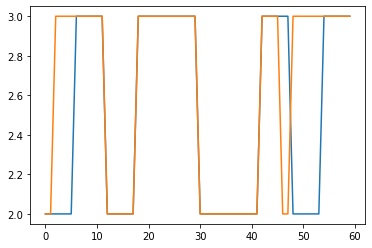

In [164]:

plt.plot(Y_TEST)
plt.plot(Y_PRED)

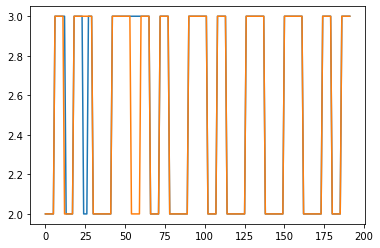

In [167]:
plt.plot(X)
plt.plot(Y)

In [ ]:
plt.predict()

In [119]:
test_epochs=mne.concatenate_epochs([epochs[:32]]+[epochs[1]]*160)

Not setting metadata
Not setting metadata
192 matching events found
No baseline correction applied
0 bad epochs dropped


In [124]:
#X,Y=SST.transform(test_epochs.copy().crop(0,4),xy_flg=True)

In [125]:
search.fit(test_epochs.copy().crop(0,4),Y)

lol
lol
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)


- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization 

[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from t

Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Pr

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsavera

Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pa


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Set


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Pr

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsavera

Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot


C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\pipeline.py",

   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
 

    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (sub

    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Desig

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
  

    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (sub

    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\

   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
 

    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (sub

    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Desig

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
  

    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (sub

    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\

C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\pipeline.py",

lol
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Up

- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Pick

Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenle

Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh 

Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
-

- Filter length: 141 samples (0.881 sec)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 /

[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root

0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutof

- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to 

Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]


Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsave


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Pr

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsavera

C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\pipeline.py",

0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutof

- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to 

Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]


Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsave


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Pr

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsavera

Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pa


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Set


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Pr

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsavera

C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\pipeline.py",

0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutof

- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to 

Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]


Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsave


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Pr

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsavera

Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pa


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Set


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Pr

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsavera

C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\pipeline.py",

lol
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Up

- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Pick

Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenle

Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh 


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Pr

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsavera

Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pa


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Set


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Pr

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsavera

Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot


C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\pipeline.py",

   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
 

    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (sub

    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Desig

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
  

    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (sub

    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\

   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
 

    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (sub

    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Desig

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
  

    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (sub

    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\

C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\pipeline.py",

0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutof

- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to 

Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]


Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsave


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Pr

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsavera

Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pa


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Set


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Pr

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsavera

C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\pipeline.py",

lol
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Up

- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Pick

Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenle

Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh 


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Pr

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsavera

Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pa


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Set


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Pr

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsavera

Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot


C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\pipeline.py",

   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
 

    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (sub

    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Desig

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
  

    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (sub

    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\

   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
 

    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (sub

    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Desig

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
  

    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (sub

    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\

   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter

C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\pipeline.py",

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsavera

Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pa


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Set


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Pr

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsavera

Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pa


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Set


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Pr

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 192) + inhomogeneous part.

In [126]:
Y.shape

(192,)

In [107]:
search

GridSearchCV(estimator=Pipeline(steps=[('SST',
                                        SourceSpaceTransformer_2(clusters=array([ 7, 16,  6, ..., 10, 10, 10]),
                                                                 cov='cov',
                                                                 fwd={'_orig_sol': array([[-108.73198975,   61.49587709,  -31.66127443, ...,  -38.37729097,
          18.77039096,   14.98657042],
       [-128.04076892,  131.92984284,   38.37732845, ...,  -32.12365756,
          22.91121737,   22.53265745],
       [ -31.49970849,  136.79250989,  111.0762157 , ...,...
       [-0.63759122, -0.55154879, -0.53783968]]),
                                                                      'source_ori': 1 (FIFFV_MNE_FIXED_ORI),
                                                                      'src': <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=10242>, <surface (rh), n_vertices=163842, n_used=10242>] head coords, subject 'fsaverage', ~25.6 MB>,
  

In [108]:
search.best_score_

nan

In [64]:
preditions=[]
trues=[]
epochs_test=epochs[32:]
for i in range(len(epochs_test)):
    drdr_=SST.transform(epochs_test[i].copy().crop(0,5))
    svc_grid.predict(drdr_[0])
    
    preditions.append(svc_grid.predict(drdr_[0]))
    trues.append(drdr_[1])
    

0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper 

- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Pick

Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenle

Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh 


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Pr

In [65]:
preditions=np.array(preditions)

In [66]:
trues=np.array(trues)

In [67]:
[accuracy_score(preditions[:,i],trues[:,i]) for i in range(preditions.shape[1])]

[0.7, 0.8, 0.8, 0.8, 0.9, 0.9, 1.0, 1.0, 1.0]

In [68]:
drdr_[1]

array([2, 2, 2, 2, 2, 2, 2, 2, 2])

1.0

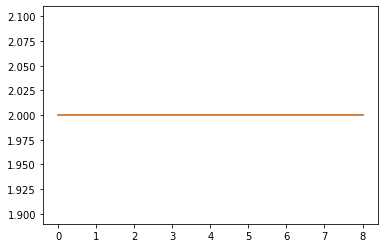

In [69]:
plt.plot(svc_grid.predict(drdr_[0]))
plt.plot(drdr_[1])
accuracy_score(svc_grid.predict(drdr_[0]),drdr_[1])

In [87]:

import SourceSpaceEstimator_36 as sst

In [88]:
SST=sst.SourceSpaceEsimator_2(param=1,fwd=fwd,cov='cov',subject='fsaverage',subjects_dir='ss',
                                 info=epochs.info,clusters=clusters,inv=inv)

lol


In [89]:
#Y=SST.transform(epochs[:20].copy().crop(0,4),xy_flg=False)

In [90]:
SST.fit(epochs[:32].copy().crop(0,4))
#drdr=SST.transform(epochs[:20].copy().crop(0,4),concat=True)

0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper 

- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Pick

Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenle

Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh 

- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 

    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalizatio

[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 

- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a n

    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalizatio

[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[

[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple an

- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 

    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalizatio

[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Set the SVM


SourceSpaceEsimator_2(clusters=array([ 6,  0, 10, ...,  7,  7,  7]), cov='cov',
                      fwd={'_orig_sol': array([[-108.73198975,   61.49587709,  -31.66127443, ...,  -38.37729097,
          18.77039096,   14.98657042],
       [-128.04076892,  131.92984284,   38.37732845, ...,  -32.12365756,
          22.91121737,   22.53265745],
       [ -31.49970849,  136.79250989,  111.0762157 , ...,  -23.75126535,
          25.97510267,   29.14171004],
       ...,
       [  11.919555...
       [-0.333074  , -0.79209842, -0.51150958],
       [-0.53277487, -0.70385906, -0.46982301],
       [-0.63759122, -0.55154879, -0.53783968]]),
                           'source_ori': 1 (FIFFV_MNE_FIXED_ORI),
                           'src': <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=10242>, <surface (rh), n_vertices=163842, n_used=10242>] head coords, subject 'fsaverage', ~25.6 MB>,
                           'units': 'Am'},
                      param=1, subject='fsaverage', subjects_

In [91]:
X,Y=SST.predict(epochs[:32].copy().crop(0,4))
#drdr=SST.transform(epochs[:20].copy().crop(0,4),concat=True)

0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper 

- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Pick

Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenle

Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh 


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Pr

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsavera

Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pa


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Set


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Pr

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsavera

In [42]:
X,Y=SST.predict(epochs[:32].copy().crop(0,4),xy_flg=True)

0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper 

- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Pick

Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenle

Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh 


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Pr

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsavera

Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pa


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Set


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Pr

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsavera

In [43]:
Y_PRED,Y_TEST=SST.predict(epochs[32:].copy().crop(0,4),xy_flg=True)

0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper 

- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Pick

Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenle

Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh 

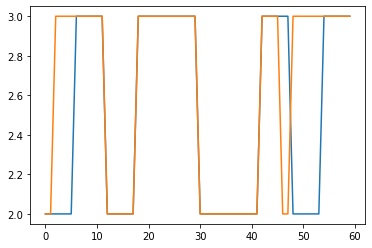

In [92]:

plt.plot(Y_TEST)
plt.plot(Y_PRED)

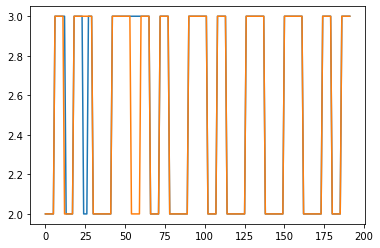

In [93]:
plt.plot(X)
plt.plot(Y)

In [ ]:
plt.predict()

In [119]:
test_epochs=mne.concatenate_epochs([epochs[:32]]+[epochs[1]]*160)

Not setting metadata
Not setting metadata
192 matching events found
No baseline correction applied
0 bad epochs dropped


In [111]:
clf = Pipeline([('SST', SST)])


#svc=SVC(random_state=rs)
skf = StratifiedKFold(n_splits=4)


param_grid = { 'SST__param': [1,2]}

search = GridSearchCV(clf, param_grid, scoring='accuracy', cv=skf)

In [112]:
search.fit(epochs[:32].copy().crop(0,4),Y[:32])

lol
lol
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)


- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization 

[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from t

Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Pr

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsavera

Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pa


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Set

C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\CBI\Desktop\Untitled Folder\SourceSpaceEstimator_36.py", line 204, in fit
    a,b=self.make_training_set(np.array(epochs_data_train),epochs.events, xy_flg=True)
AttributeError: 'list' object has no attribute 'events'

  warnings.warn("Estimator fit failed. The score on this train-test"


[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from t

Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Pr

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsavera

Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pa


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Set


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Pr

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\CBI\Desktop\Untitled Folder\SourceSpaceEstimator_36.py", line 204, in fit
    a,b=self.make_training_set(np.array(epochs_data_train),epochs.events, xy_flg=True)
AttributeError: 'list' object has no attribute 'events'

  warnings.warn("Estimator fit failed. The score on this train-test"


[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from t

Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Pr

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsavera

Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pa


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Set


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Pr

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\CBI\Desktop\Untitled Folder\SourceSpaceEstimator_36.py", line 204, in fit
    a,b=self.make_training_set(np.array(epochs_data_train),epochs.events, xy_flg=True)
AttributeError: 'list' object has no attribute 'events'

  warnings.warn("Estimator fit failed. The score on this train-test"


Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data

Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Pr

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsavera

Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pa


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Set


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Pr

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\CBI\Desktop\Untitled Folder\SourceSpaceEstimator_36.py", line 204, in fit
    a,b=self.make_training_set(np.array(epochs_data_train),epochs.events, xy_flg=True)
AttributeError: 'list' object has no attribute 'events'

  warnings.warn("Estimator fit failed. The score on this train-test"


[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from t

Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Pr

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsavera

Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pa


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Set


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Pr

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\CBI\Desktop\Untitled Folder\SourceSpaceEstimator_36.py", line 204, in fit
    a,b=self.make_training_set(np.array(epochs_data_train),epochs.events, xy_flg=True)
AttributeError: 'list' object has no attribute 'events'

  warnings.warn("Estimator fit failed. The score on this train-test"


[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from t

Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Pr

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsavera

Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pa


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Set


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Pr

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\CBI\Desktop\Untitled Folder\SourceSpaceEstimator_36.py", line 204, in fit
    a,b=self.make_training_set(np.array(epochs_data_train),epochs.events, xy_flg=True)
AttributeError: 'list' object has no attribute 'events'

  warnings.warn("Estimator fit failed. The score on this train-test"


Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data

Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Pr

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsavera

Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pa


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Set


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Pr

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\CBI\Desktop\Untitled Folder\SourceSpaceEstimator_36.py", line 204, in fit
    a,b=self.make_training_set(np.array(epochs_data_train),epochs.events, xy_flg=True)
AttributeError: 'list' object has no attribute 'events'

  warnings.warn("Estimator fit failed. The score on this train-test"


Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data

Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Pr

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsavera

Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pa


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Set


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Pr

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\CBI\Desktop\Untitled Folder\SourceSpaceEstimator_36.py", line 204, in fit
    a,b=self.make_training_set(np.array(epochs_data_train),epochs.events, xy_flg=True)
AttributeError: 'list' object has no attribute 'events'

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\CBI\anaconda3\envs\source_space\lib\site-packages\sklearn\model_se

Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data

Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Pr

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsavera

Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pa


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Set


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Pr

    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source cova

    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsavera

Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pa


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('SST',
                                        SourceSpaceEsimator_2(clusters=array([ 6,  0, 10, ...,  7,  7,  7]),
                                                              cov='cov',
                                                              fwd={'_orig_sol': array([[-108.73198975,   61.49587709,  -31.66127443, ...,  -38.37729097,
          18.77039096,   14.98657042],
       [-128.04076892,  131.92984284,   38.37732845, ...,  -32.12365756,
          22.91121737...
       [-0.53277487, -0.70385906, -0.46982301],
       [-0.63759122, -0.55154879, -0.53783968]]),
                                                                   'source_ori': 1 (FIFFV_MNE_FIXED_ORI),
                                                                   'src': <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=10242>, <surface (rh), n_vertices=163842, n_used=10242>] head coord

In [115]:
search.best_estimator_

Pipeline(steps=[('SST',
                 SourceSpaceEsimator_2(clusters=array([ 6,  0, 10, ...,  7,  7,  7]),
                                       cov='cov',
                                       fwd={'_orig_sol': array([[-108.73198975,   61.49587709,  -31.66127443, ...,  -38.37729097,
          18.77039096,   14.98657042],
       [-128.04076892,  131.92984284,   38.37732845, ...,  -32.12365756,
          22.91121737,   22.53265745],
       [ -31.49970849,  136.79250989,  111.0762157 , ...,  -23.75126535,
          25.97510267,   29.1...
       [-0.333074  , -0.79209842, -0.51150958],
       [-0.53277487, -0.70385906, -0.46982301],
       [-0.63759122, -0.55154879, -0.53783968]]),
                                            'source_ori': 1 (FIFFV_MNE_FIXED_ORI),
                                            'src': <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=10242>, <surface (rh), n_vertices=163842, n_used=10242>] head coords, subject 'fsaverage', ~25.6 MB>,
              

In [110]:
clf.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'SST', 'SST__param', 'SST__fwd', 'SST__cov', 'SST__subject', 'SST__subjects_dir', 'SST__info', 'SST__clusters', 'SST__inv', 'SST__labels_i_need_names', 'SST__clusters_num', 'SST__lamb', 'SST__random_state'])

In [126]:
Y.shape

(192,)

In [107]:
search

GridSearchCV(estimator=Pipeline(steps=[('SST',
                                        SourceSpaceTransformer_2(clusters=array([ 7, 16,  6, ..., 10, 10, 10]),
                                                                 cov='cov',
                                                                 fwd={'_orig_sol': array([[-108.73198975,   61.49587709,  -31.66127443, ...,  -38.37729097,
          18.77039096,   14.98657042],
       [-128.04076892,  131.92984284,   38.37732845, ...,  -32.12365756,
          22.91121737,   22.53265745],
       [ -31.49970849,  136.79250989,  111.0762157 , ...,...
       [-0.63759122, -0.55154879, -0.53783968]]),
                                                                      'source_ori': 1 (FIFFV_MNE_FIXED_ORI),
                                                                      'src': <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=10242>, <surface (rh), n_vertices=163842, n_used=10242>] head coords, subject 'fsaverage', ~25.6 MB>,
  

In [108]:
search.best_score_

nan

In [64]:
preditions=[]
trues=[]
epochs_test=epochs[32:]
for i in range(len(epochs_test)):
    drdr_=SST.transform(epochs_test[i].copy().crop(0,5))
    svc_grid.predict(drdr_[0])
    
    preditions.append(svc_grid.predict(drdr_[0]))
    trues.append(drdr_[1])
    

0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh : 9138 vertices>, <Label | fsaverage, 'precentral-lh', lh : 10740 vertices>, <Label | fsaverage, 'precentral-rh', rh : 10705 vertices>]
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper 

- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Pick

Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenle

Processing epoch : 1 / 1
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing noise-normalization factors (sLORETA)...
[done]
Picked 64 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1
[done]
0 files missing from root.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage
Reading labels from parcellation...
   read 35 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\CBI\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
[<Label | fsaverage, 'postcentral-lh', lh : 9519 vertices>, <Label | fsaverage, 'postcentral-rh', rh 


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 sec)

Setting up band-pass filter from 15 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 141 samples (0.881 sec)

Pr

In [65]:
preditions=np.array(preditions)

In [66]:
trues=np.array(trues)

In [67]:
[accuracy_score(preditions[:,i],trues[:,i]) for i in range(preditions.shape[1])]

[0.7, 0.8, 0.8, 0.8, 0.9, 0.9, 1.0, 1.0, 1.0]

In [68]:
drdr_[1]

array([2, 2, 2, 2, 2, 2, 2, 2, 2])

1.0

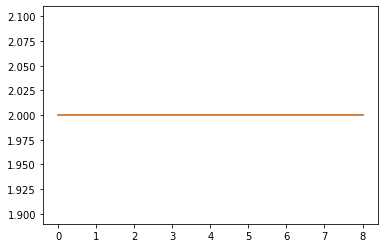

In [69]:
plt.plot(svc_grid.predict(drdr_[0]))
plt.plot(drdr_[1])
accuracy_score(svc_grid.predict(drdr_[0]),drdr_[1])